### Imagenet

Largest image classification dataset at this point of time.

Url: http://image-net.org/

Our setup: classify from a set of 1000 classes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#classes' names are stored here
import pickle
from sys import platform


    #classes' names are stored here
#!/usr/bin/env python
"""
convert dos linefeeds (crlf) to unix (lf)
usage: dos2unix.py 
"""
original = "classes.pkl"
destination = "classes_unix.pkl"

content = ''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))

print("Done. Saved %s bytes." % (len(content)-outsize))

classes = pickle.load(open('classes_unix.pkl','rb'))
print (classes[::100])

    

Done. Saved 2000 bytes.
['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


### Using pre-trained model: inception
Keras has a number of models for which you can use pre-trained weights. The interface is super-straightforward:

In [ ]:
import tensorflow as tf

In [14]:
import keras
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Predict class probabilities

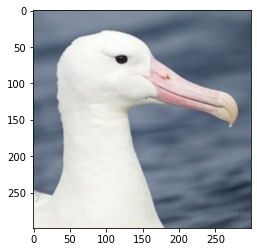

top-10 classes are:
0.9282	albatross
0.0016	turnstile
0.0008	drake
0.0005	collie
0.0004	hammerhead
0.0004	Shetland sheepdog
0.0004	nipple
0.0004	cello
0.0004	goose


In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('albatross.jpg'), (299,  299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32') * 255)

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

### Having fun with pre-trained nets

In [ ]:
if platform == 'win32':
    import wget
    wget.download('https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg', out = 'img.jpg')
else:
    !wget https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg -O img.jpg

--2021-04-09 17:35:03--  https://upload.wikimedia.org/wikipedia/en/b/b9/Terminator-2-judgement-day.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13726 (13K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  13.40K  --.-KB/s    in 0.001s  

2021-04-09 17:35:03 (9.35 MB/s) - ‘img.jpg’ saved [13726/13726]



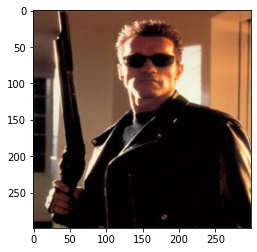

top-10 classes are:
0.4340	sunglass
0.3304	sunglasses
0.0397	rifle
0.0344	trench coat
0.0138	bassoon
0.0096	assault rifle
0.0073	cloak
0.0053	electric guitar
0.0052	suit


In [ ]:
img = resize(plt.imread('img.jpg'), (299,299))
plt.imshow(img)
plt.show()

img_preprocessed = zoo.inception_v3.preprocess_input(img[None].astype('float32') * 255.)

probs = model.predict(img_preprocessed)

labels = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are:')
for l in labels:
    print ('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))



### How do you reuse layers

Since model is just a sequence of layers, one can apply it as any other Keras model. Then you can build more layers on top of it, train them and maybe fine-tune "body" weights a bit.

In [ ]:
# img = keras.backend.Input('float32',[None,299,299,3])

neck = zoo.InceptionV3(include_top=False, weights='imagenet')(img[None])

hid = keras.layers.GlobalMaxPool2D()(neck)

hid = keras.layers.Dense(512,activation='relu')(hid)

out = keras.layers.Dense(10,activation='softmax')(hid)

#<...> loss, training, etc.

87916544/87910968 [==============================] - 1s 0us/step


# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
new_model_input = model.layers[0].input
new_model_output  = model.layers[-2].output
feature_extractor = keras.Model(inputs = new_model_input, outputs = new_model_output)
feature_extractor.summary()

In [6]:
#extract features from images
from tqdm import tqdm
#from scipy.misc import imresize
import cv2
import os
import numpy as np

try:
    if not (os.path.exists('Extracted_features.npy') and os.path.exists('Y.npy')):
        X = []
        Y = []

        #this may be a tedious process. If so, store the results in some pickle and re-use them.
        assert os.path.exists('train'), 'Download data from https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip'
        for fname in tqdm(os.listdir('train/')):
            y = int(fname.startswith("cat"))

            img = plt.imread("train/"+fname)
            img = zoo.inception_v3.preprocess_input(img)
            img = cv2.resize(img,(299,299))

            img = img[None].astype('float32') / 255.

            #features = <use network to process the image into features>
            features = feature_extractor.predict(img)

            Y.append(y)
            X.append(features)
        X = np.concatenate(X)
        np.save('Extracted_features.npy',X)
        np.save('Y.npy',Y) 
    else:
        with open('Extracted_features.npy', 'rb') as x, open('Y.npy', 'rb') as y:
            X = np.load(x)
            Y = np.load(y)
except KeyboardInterrupt:
    X = np.concatenate(X)
    np.save('Extracted_features.npy',X)
    np.save('Y.npy',Y)

In [7]:

#X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [8]:
#<split data either here or use cross-validation>
from sklearn.model_selection import train_test_split
X, val_x, Y, val_y = train_test_split(X, Y, test_size = 0.2, random_state = 0 )

__load our dakka__

![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [13]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [10]:
#Reduce dimension
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X,Y)
val_x_lda = lda.transform(val_x)

In [11]:
log = LogisticRegression()
log.fit(X_lda,Y)
pred = log.predict(val_x_lda)
print('Accuracy is',accuracy_score(val_y,pred))

Accuracy is 0.9906


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by setting var_list in the optimizer
      * `opt = tf.train.AdamOptimizer(learning_rate=...)`
      * `opt.minimize(loss,var_list=variables_you_wanna_train)`
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * you can create two update operations
      * `opt1 = tf.train.AdamOptimizer(learning_rate=lr1)`
      * `opt1.minimize(loss,var_list=head_weights)`
      * `opt2 = tf.train.AdamOptimizer(learning_rate=lr2)`
      * `opt2.minimize(loss,var_list=body_weights)`
 
### Grading
* 95% accuracy on test yields 100 points
* -10 points per 5% less accuracy

### Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 96%/97%/98%/99%/99.5% test score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [15]:
#<A whole lot of your code>
#<A whole lot of your code>
dense = keras.Sequential()
dense.add(keras.layers.Dense(input_shape = (2048,),units = 1000, kernel_initializer = keras.initializers.RandomUniform(), activation='relu'))
dense.add(keras.layers.Dense(100, kernel_initializer = keras.initializers.RandomUniform(), activation= 'relu'))
dense.add(keras.layers.Dense(1,   kernel_initializer = keras.initializers.RandomUniform() ) )
dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              2049000   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,149,201
Trainable params: 2,149,201
Non-trainable params: 0
_________________________________________________________________


In [17]:
import keras.backend as K
K.clear_session()
dense.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00008), loss ='binary_crossentropy', metrics=['accuracy'])
dense.fit(X,Y, epochs=5, batch_size=30)

Epoch 1/5
667/667 [==============================] - 11s 15ms/step - loss: 0.1346 - accuracy: 0.9616
Epoch 2/5
667/667 [==============================] - 10s 15ms/step - loss: 0.0252 - accuracy: 0.9948
Epoch 3/5
667/667 [==============================] - 10s 15ms/step - loss: 0.9030 - accuracy: 0.9211
Epoch 4/5
667/667 [==============================] - 10s 15ms/step - loss: 0.0197 - accuracy: 0.9945
Epoch 5/5
667/667 [==============================] - 10s 15ms/step - loss: 0.0246 - accuracy: 0.9947


In [18]:
dense.evaluate(val_x, val_y)

157/157 [==============================] - 1s 6ms/step - loss: 0.0519 - accuracy: 0.9920


[0.05187167972326279, 0.9919999837875366]

In [ ]:
zoo.NASNetMobile().summary()